# 2018-12-10 - Scanning all STDP Params
I'm pretty sure weights distribution won't matter for example

# TODO : Is topology any helpful ?
# TODO : Dynamic input orientation changes

# Init

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True):
    #extracts the spiketrains
    spiketrain_len = []
    for spiketrain in np.asarray(spike_array.spiketrains):
        spiketrain_len.append(len(np.array(spiketrain, dtype = float)))
    spikelen_array = np.asarray(spiketrain_len)
    
    #fit the gaussian
    x = np.linspace(0, popsize,popsize)
    y = np.asarray(spikelen_array)

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    
    #eye cancer-triggering lines
    sigma = r'$\sigma$ ' +out.fit_report(min_correl=.25).split('sigma')[1].split('+')[0]
    sigma = float(sigma.replace(' ', '').split(':')[1])
    
    if do_title :
        ax.set_title(r'$\sigma$ = %.3f ' % (sigma))
    
    return ax, sigma

def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        axs4 = plt.subplot(gs[: , 4:])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(rates * (simtime/1000), color = 'g', label = 'Input distribution')
        plt.legend()
        sigma = fit_plot(popsize, SpikesE, axs4)[1]
        
        axs4.set_xlabel('Neuron index')
        axs4.set_ylabel('Total spikes', rotation = 270)
        axs4.yaxis.tick_right()
        axs4.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig, sigma
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM

# Hyperparams

In [3]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 90  # degrees
b_theta = 30  # degrees
sparseness = .1

# Dicos

In [4]:
scan_size = 10
taus = np.linspace(5, 60, scan_size) # STDP tau constant
stdp_amps = np.linspace(.1, 6, scan_size) #stdp amplitude at tau
stdp_weight = np.linspace(.1, 8, scan_size) #initial weight for stdp synapses
stdp_max_weight = np.linspace(.1, 8, scan_size) #initial weight for stdp synapses

weight_mus = np.linspace(.1, 5, scan_size) #weight distribution for inh synapses (they are static)
delay_mus = np.linspace(1, 6, scan_size) #delay distribution for synapses

ratio_weights = np.linspace(.1, 10, scan_size) #ratio of plus over minus shape of STDP amplitudes


all_dicts = [taus, stdp_amps, stdp_weight, weight_mus, delay_mus, stdp_max_weight, ratio_weights]
titles = ['STDP Tau constant', 'STDP Amplitude constant', 'STDP initialisation weight',
         'Weights distribution mu', 'Delays distribution mus', 'STDP max weight',
         'Ratio of the STDP amplitudes']

# Showtime

TODO : utiliser MultiplicativeWeightDependence pour les inhibiteurs

TODO : pour éviter une synchronie commencer avec 250ms de "je sais rien"= bruit uniforme 

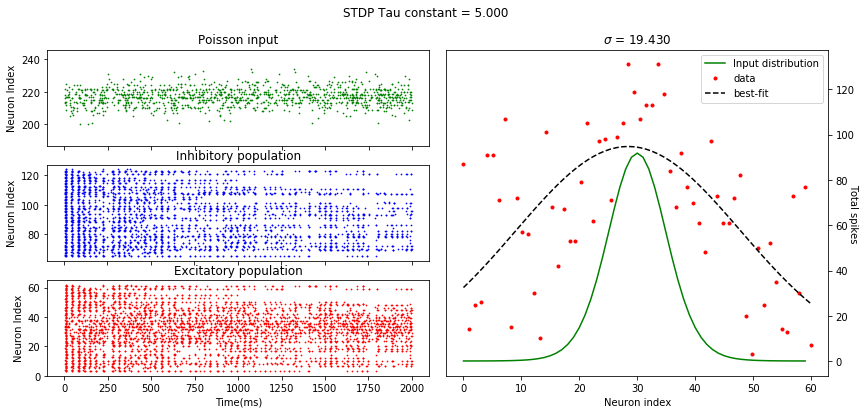

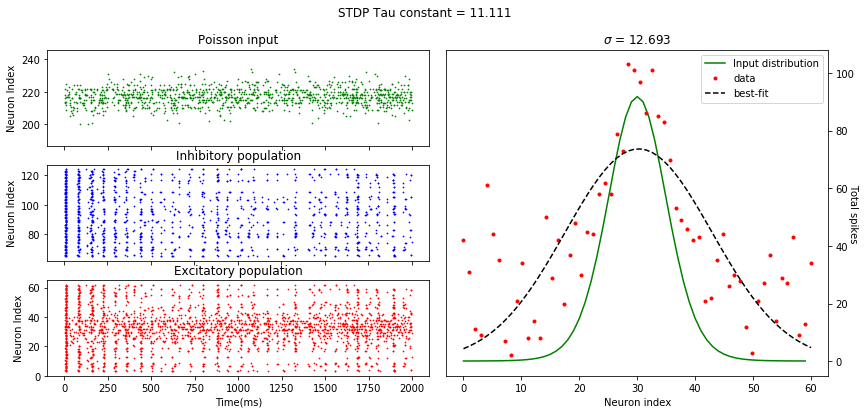

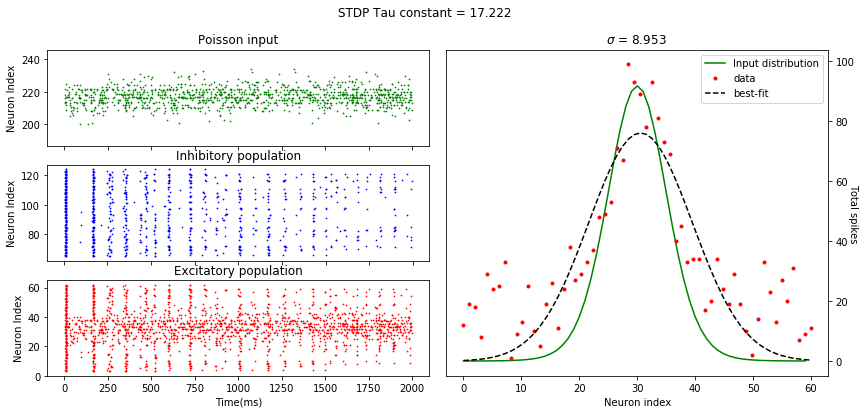

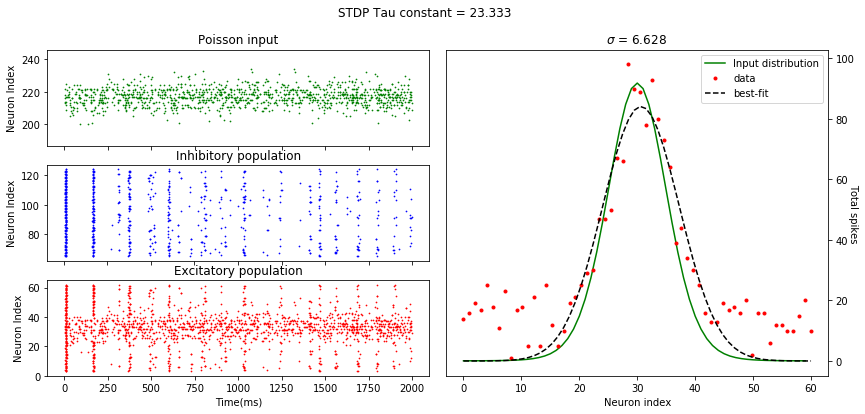

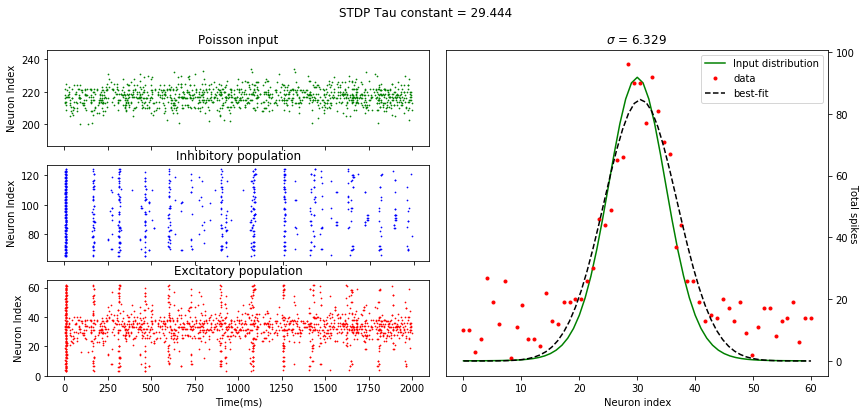

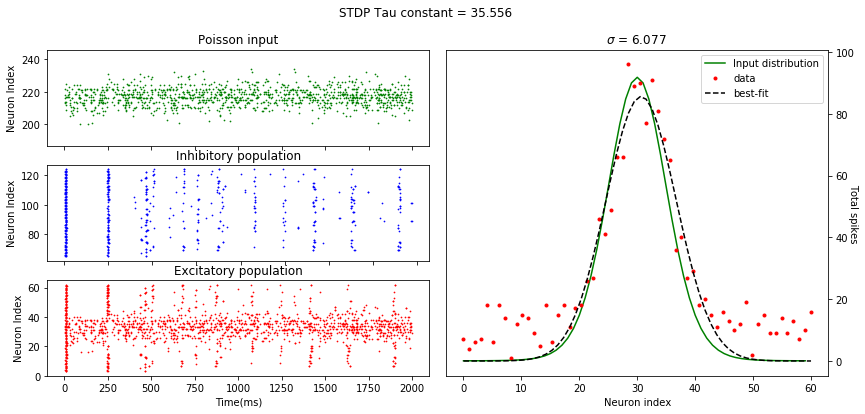

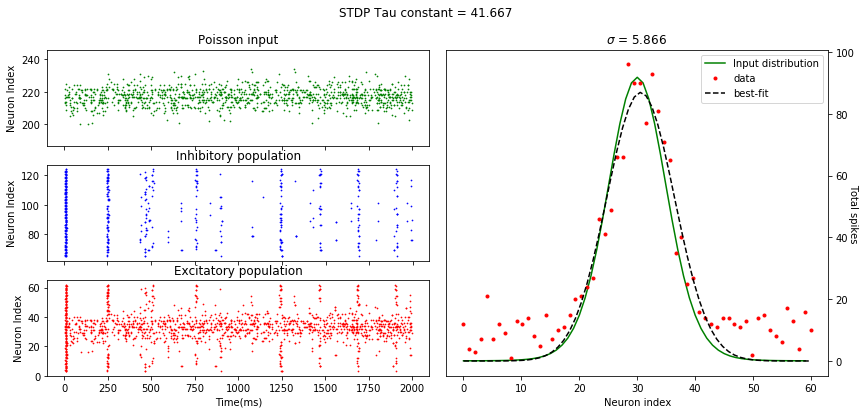

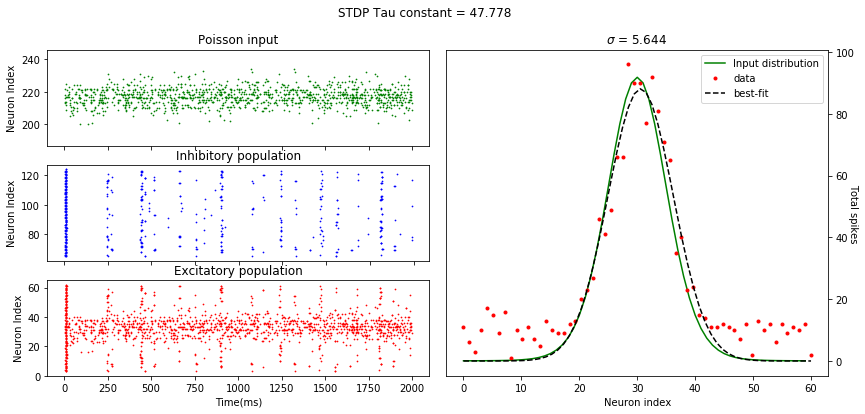

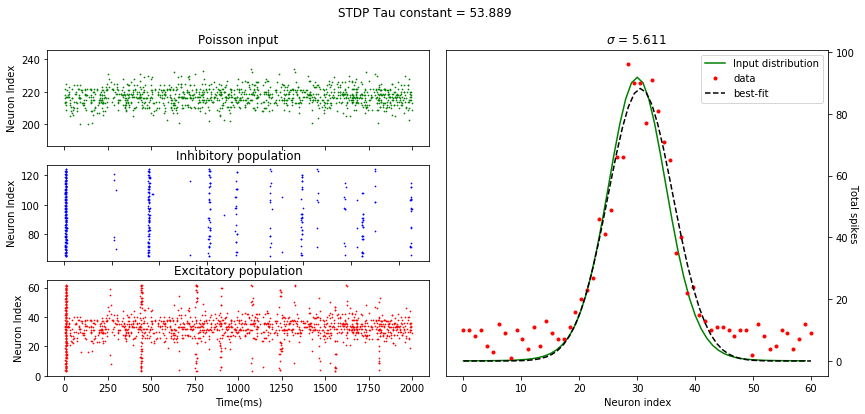

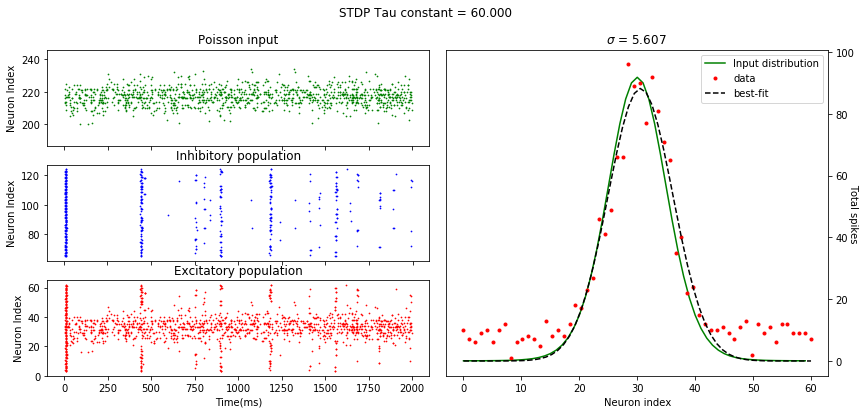

/usr/local/lib/python3.7/site-packages/pyNN/recording/__init__.py:264: UserWarning: Recorded at least one spike after t_stop
  warn("Recorded at least one spike after t_stop")


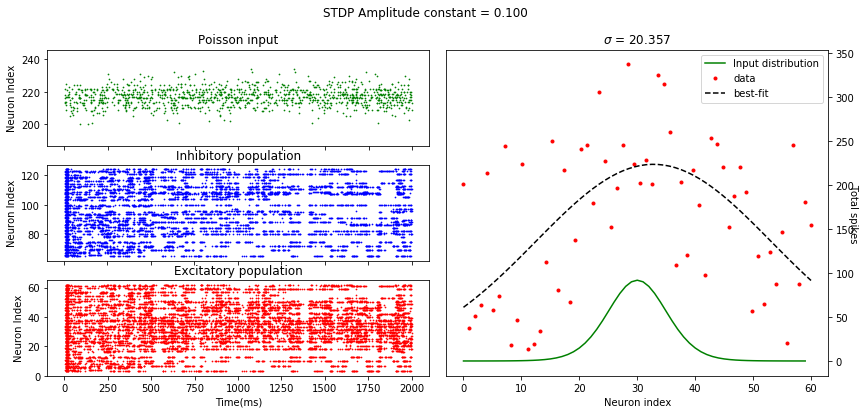

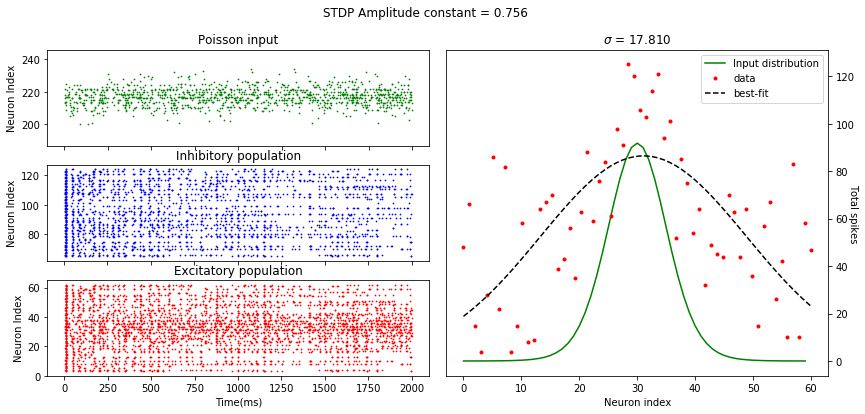

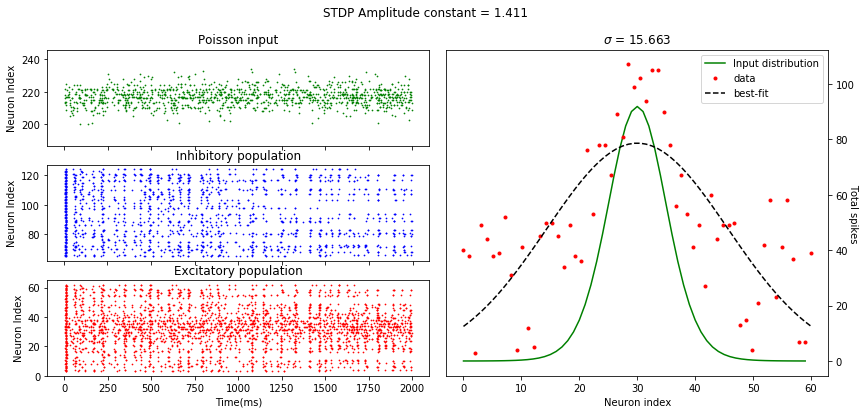

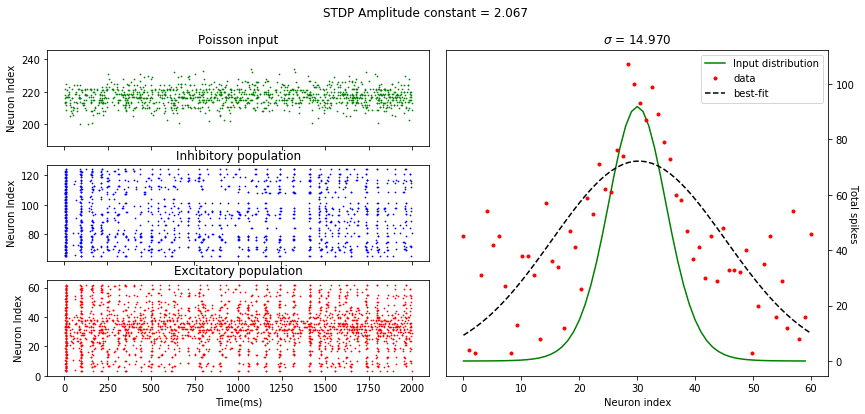

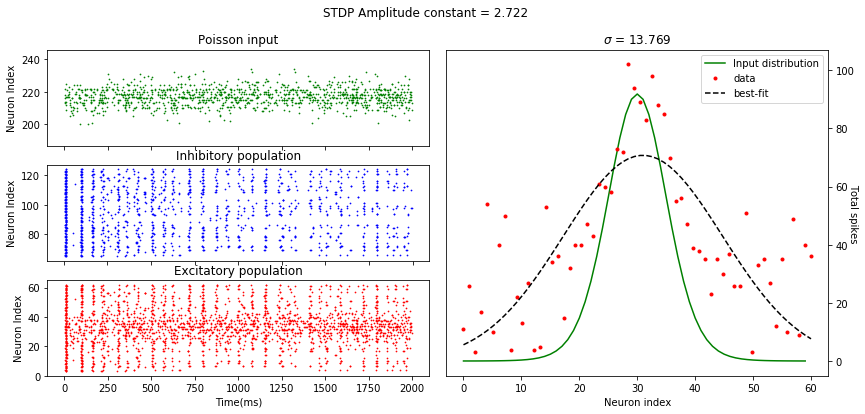

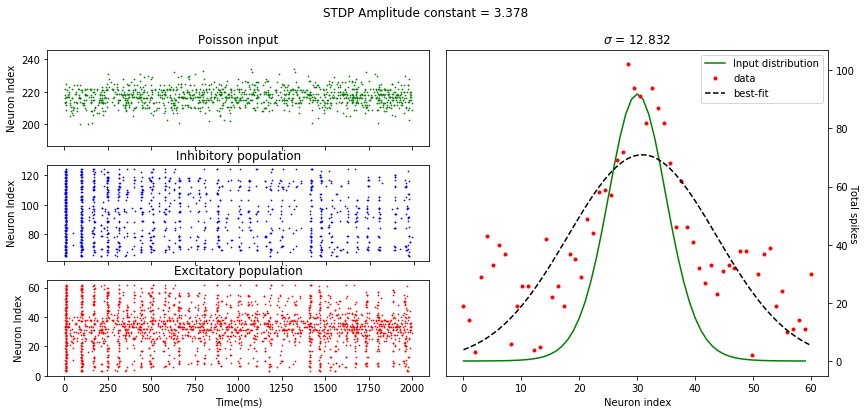

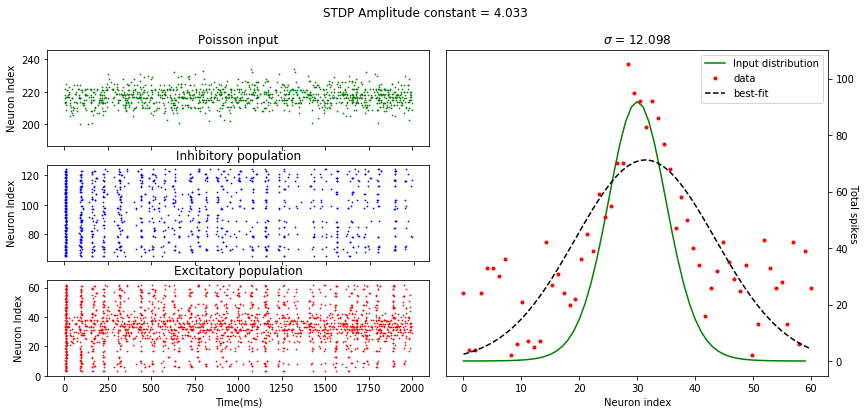

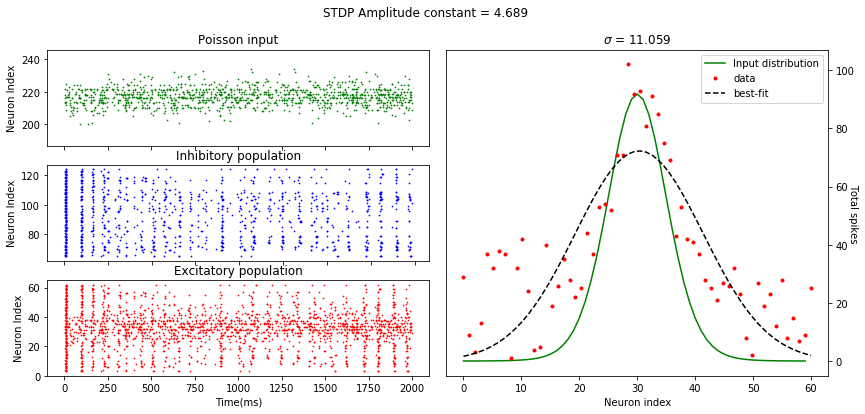

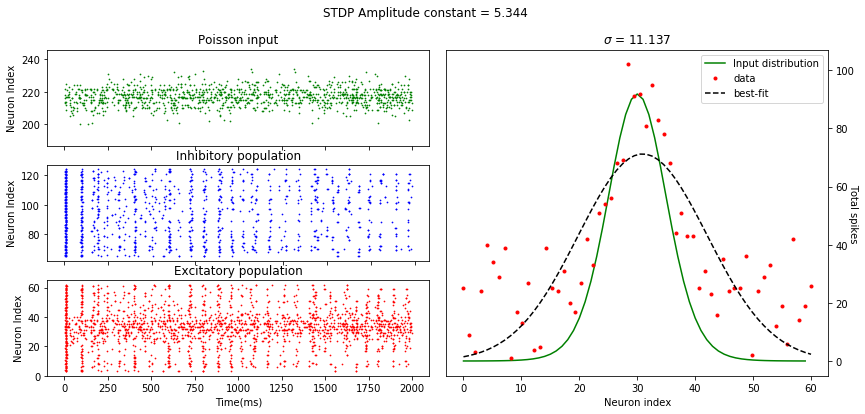

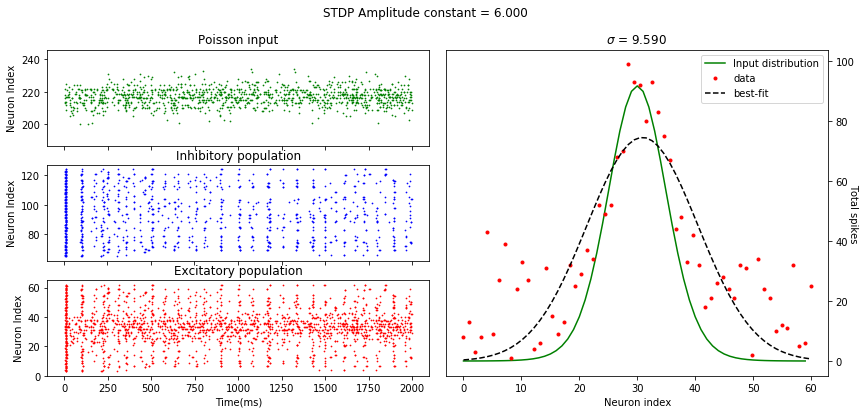

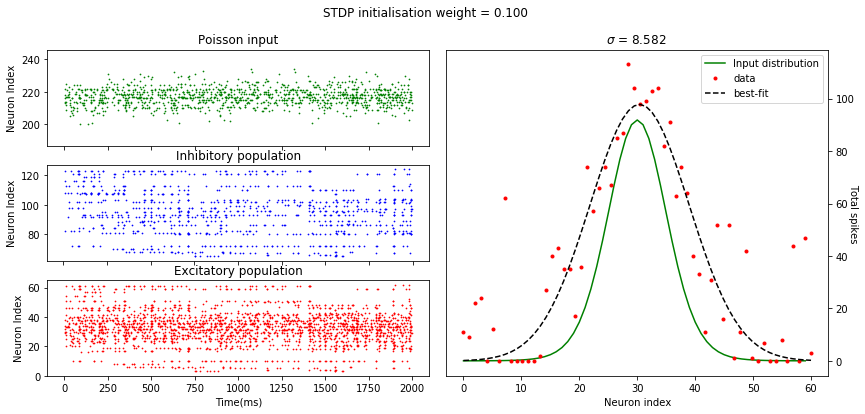

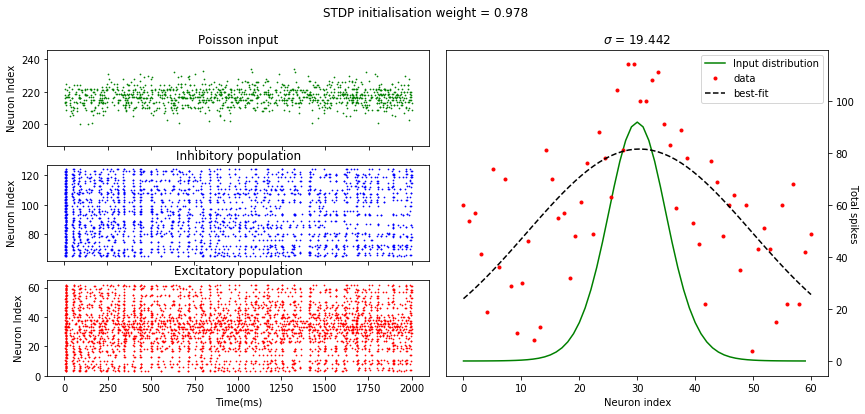

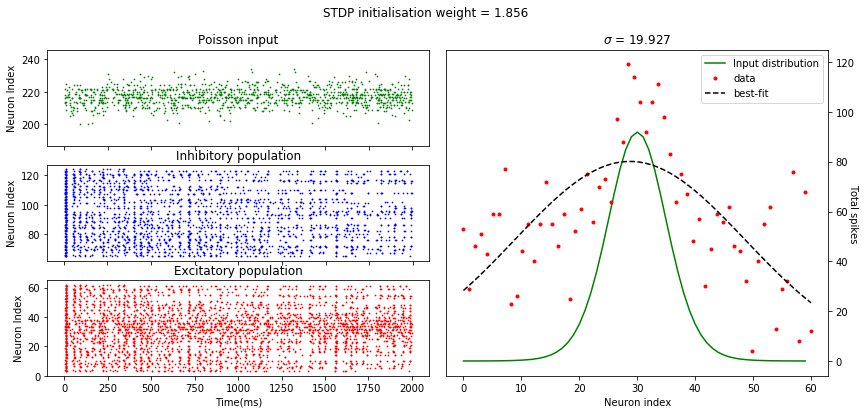

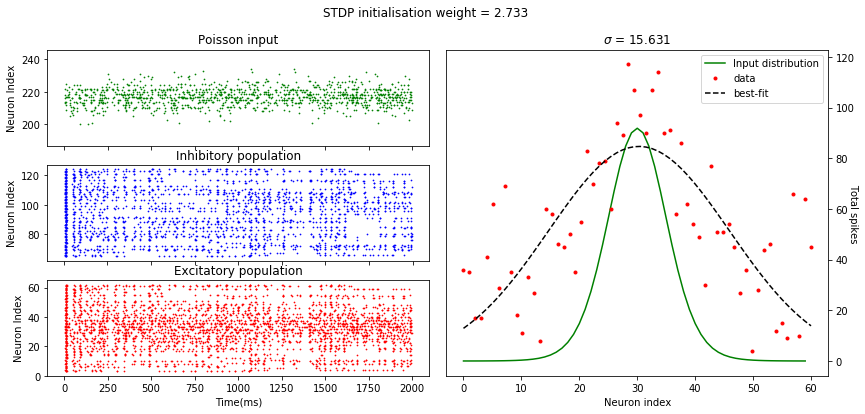

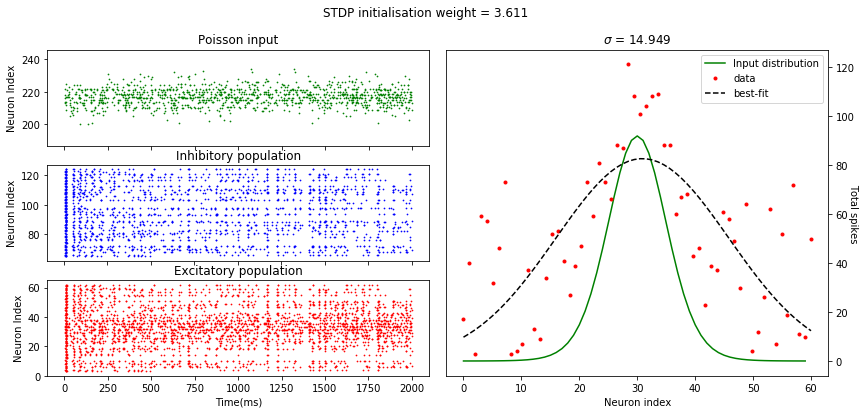

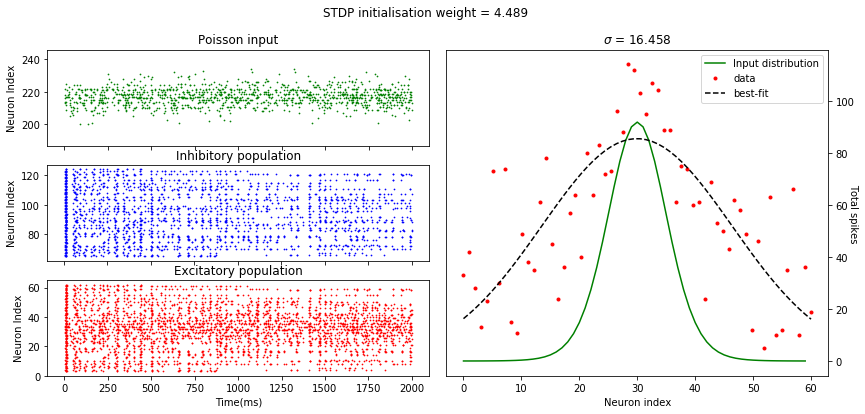

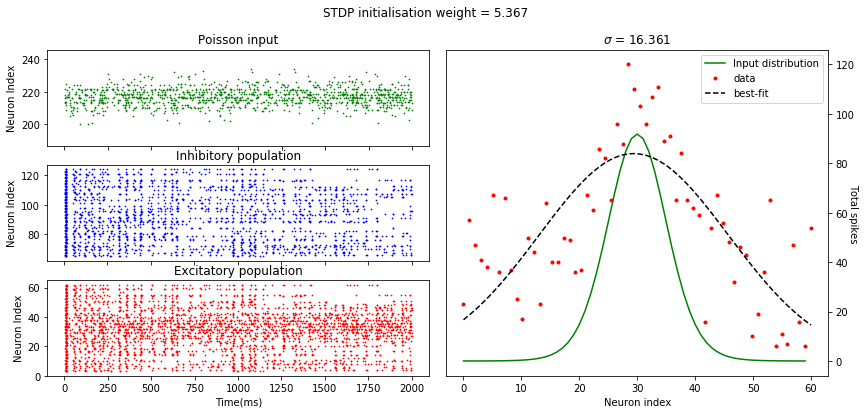

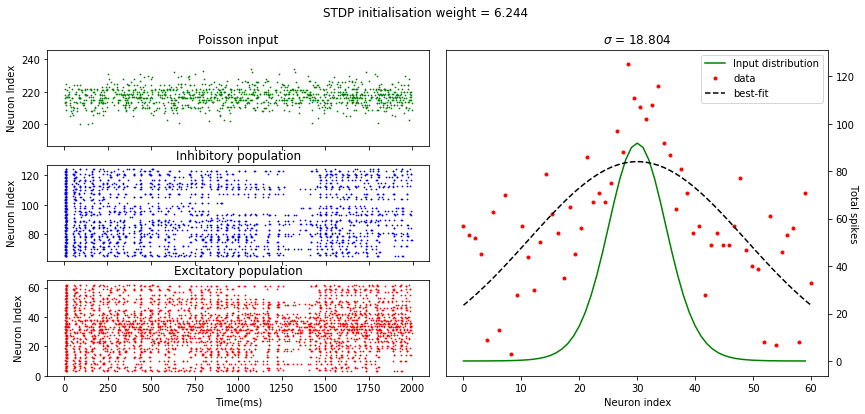

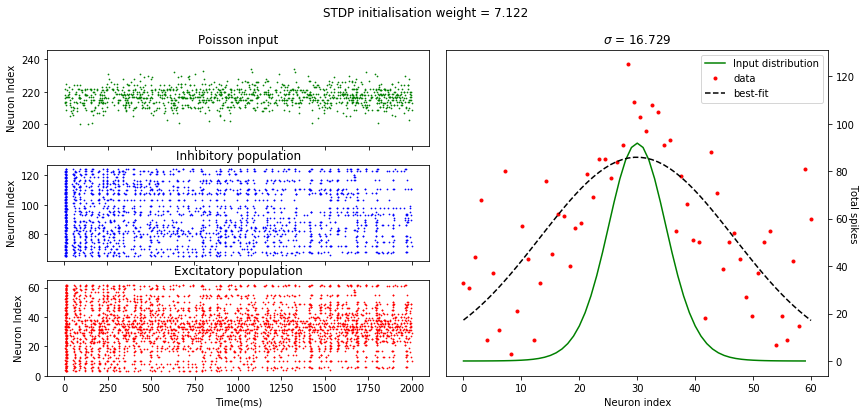

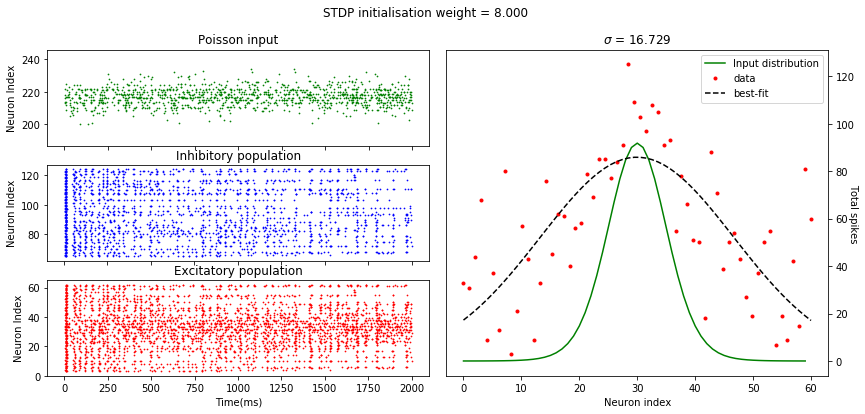

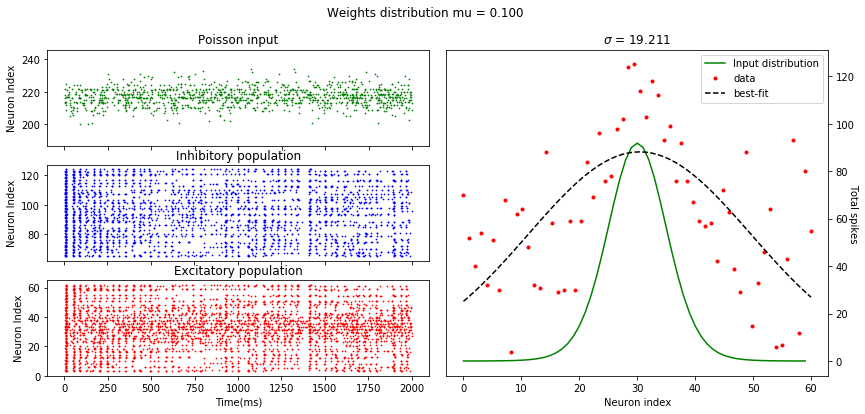

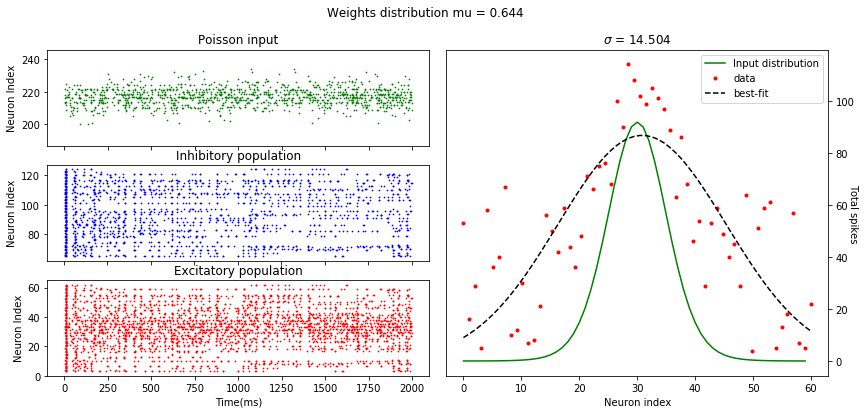

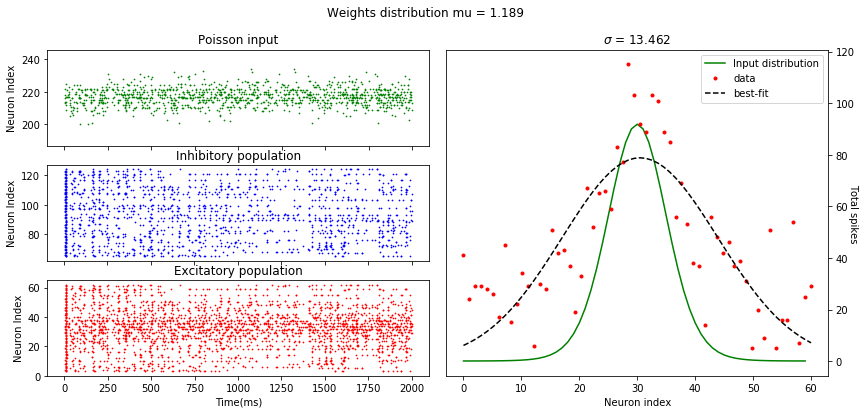

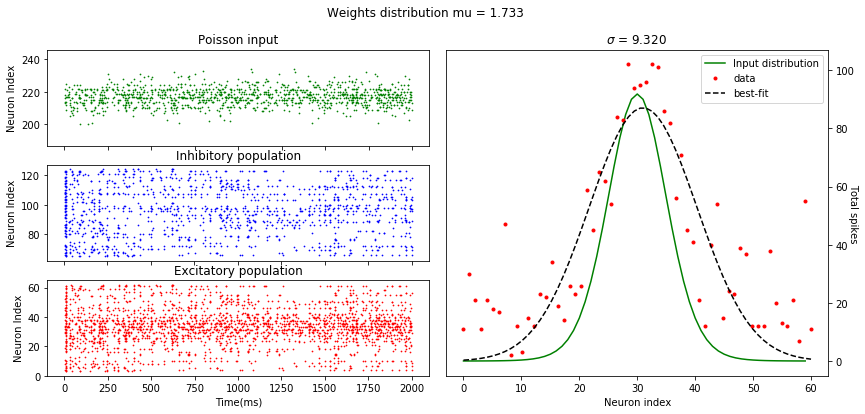

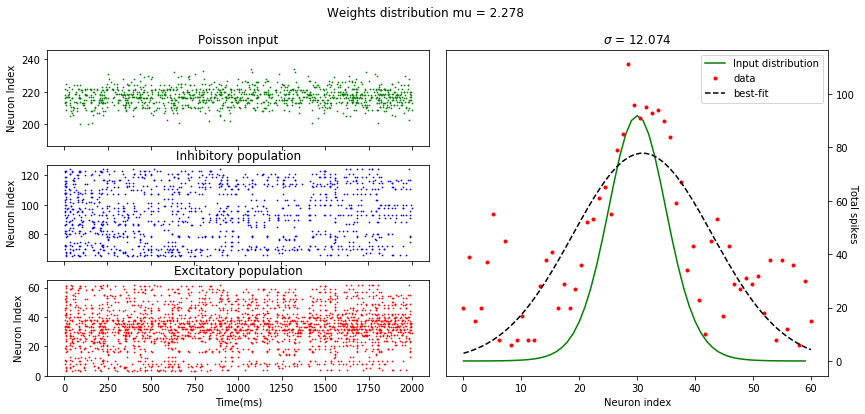

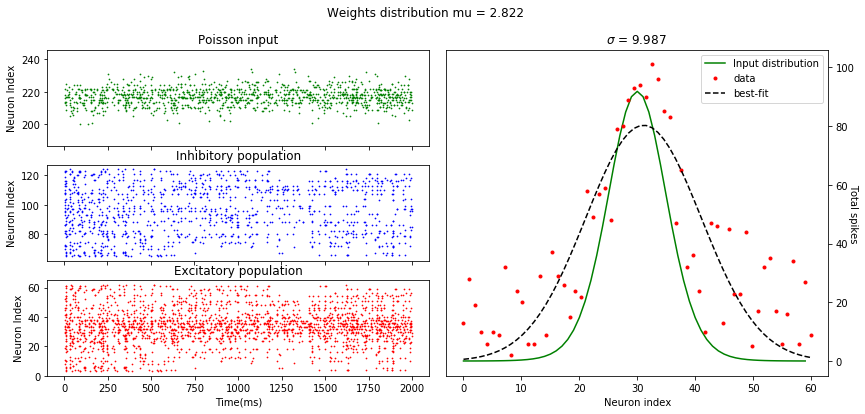

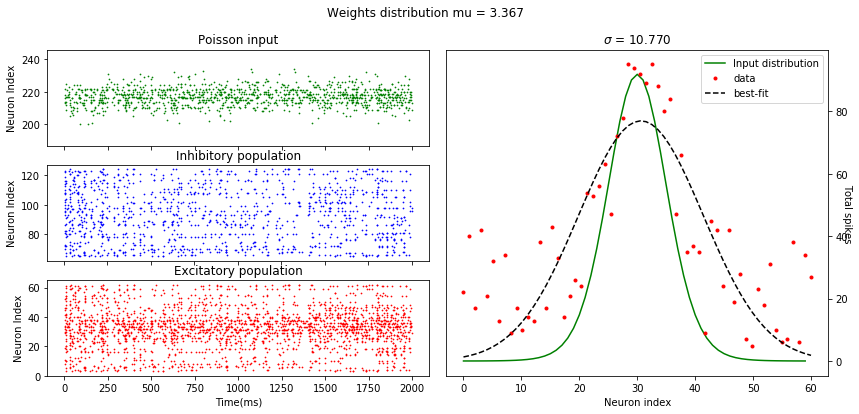

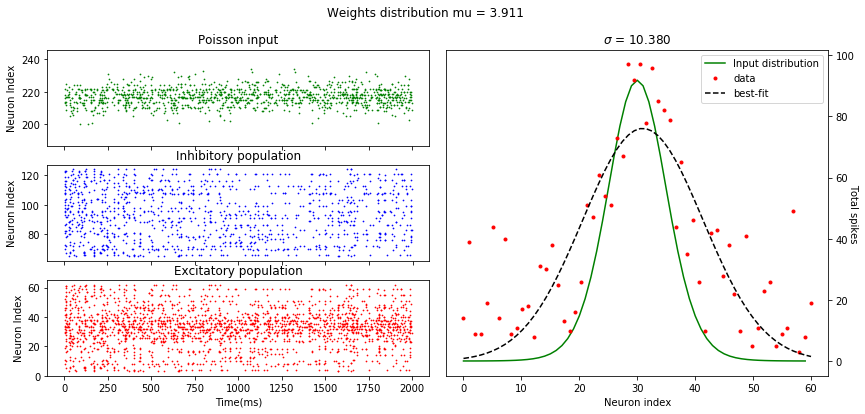

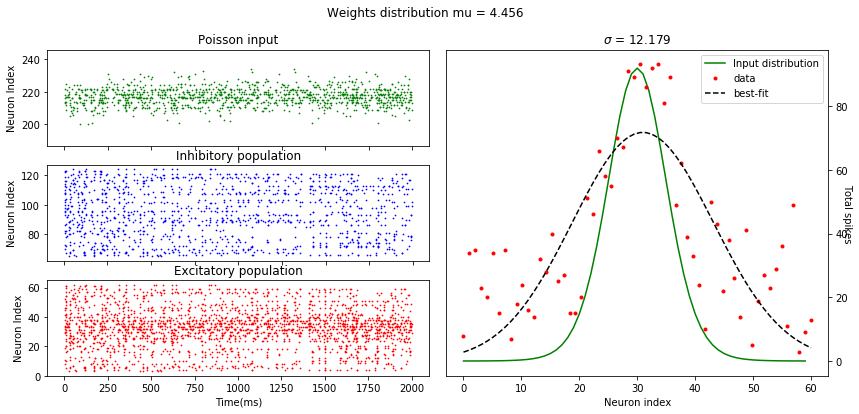

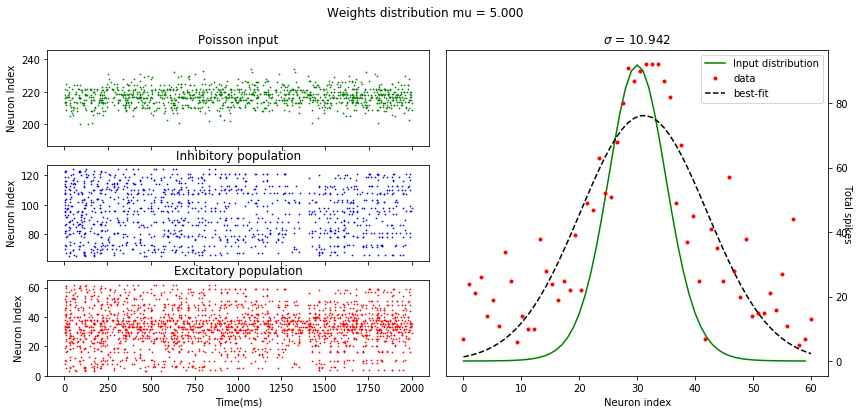

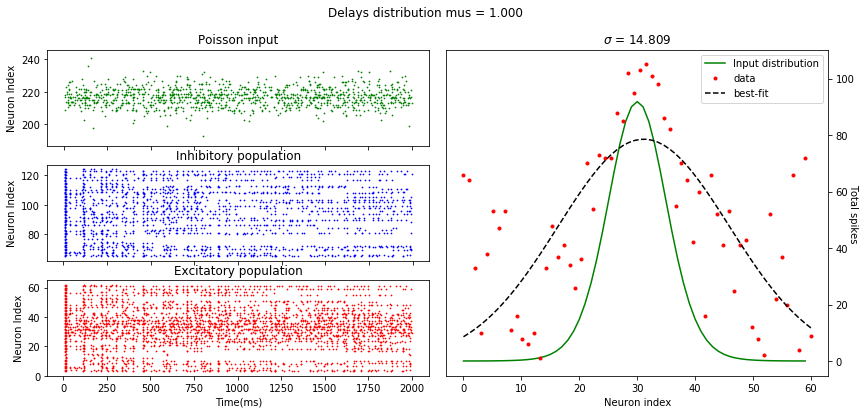

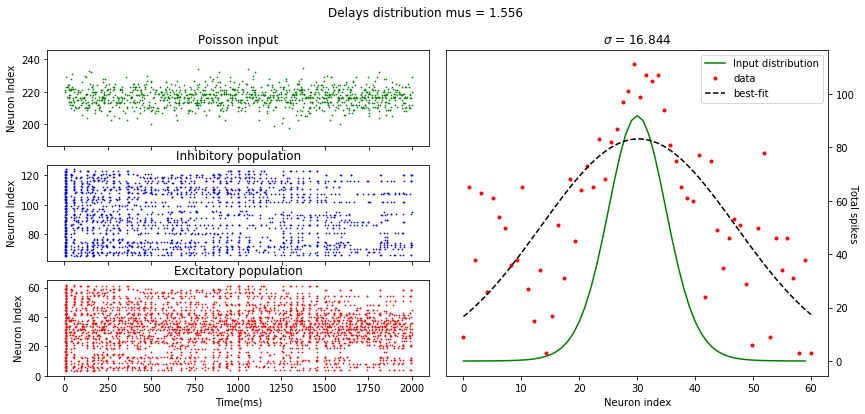

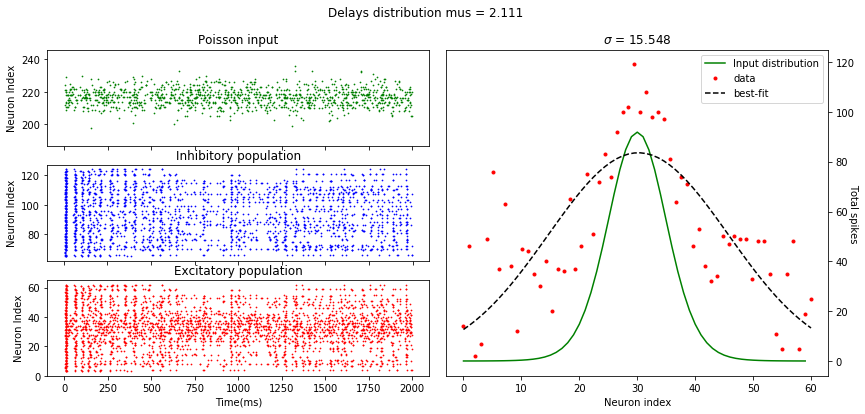

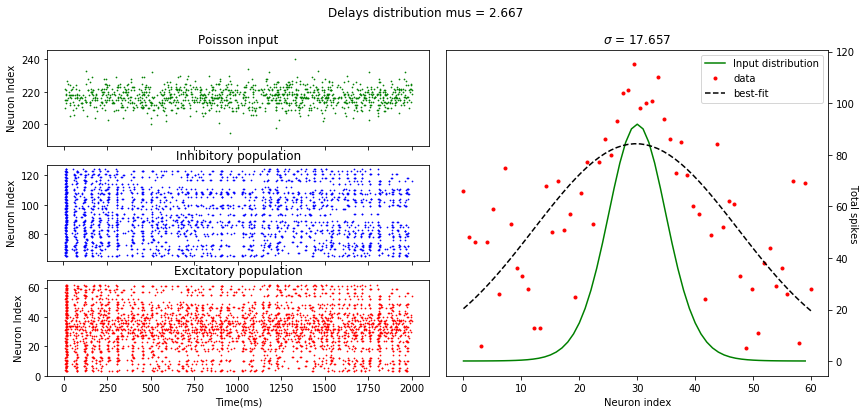

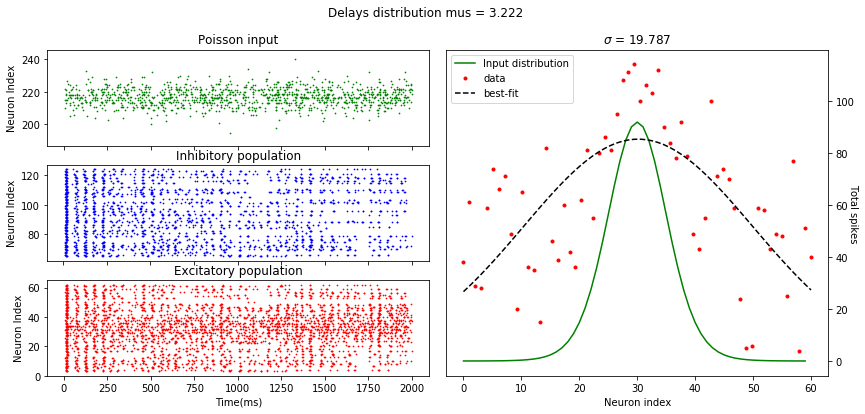

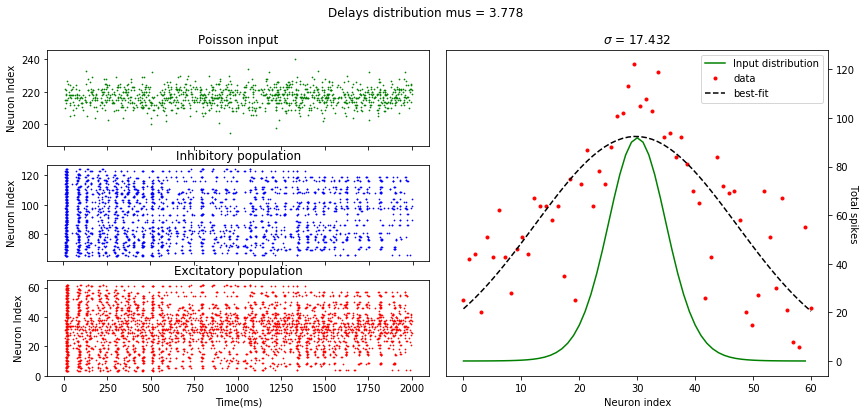

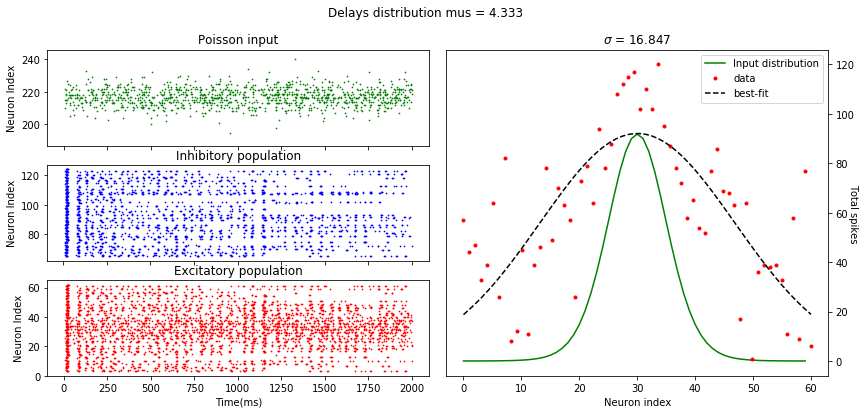

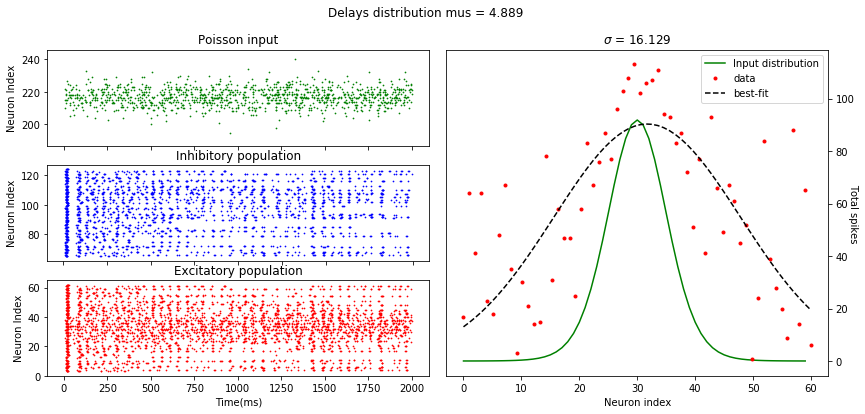

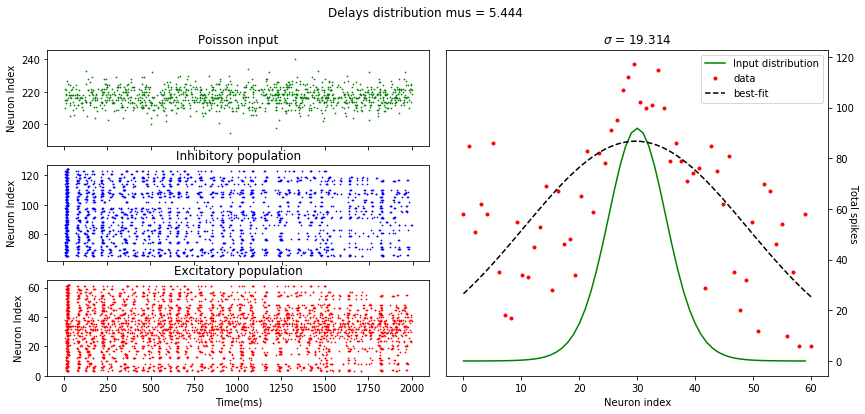

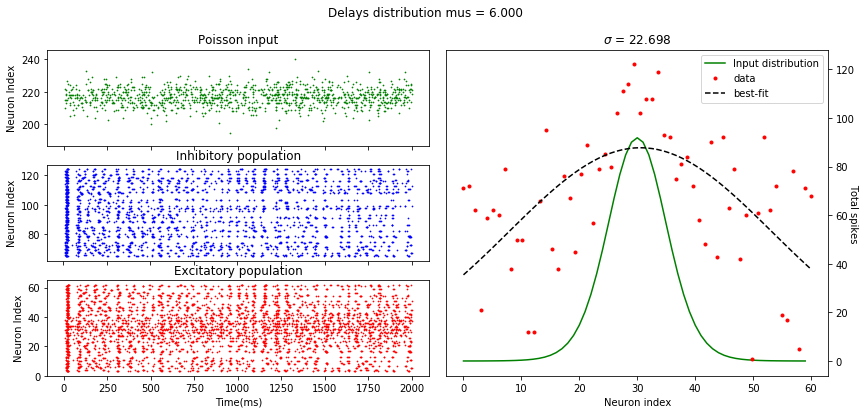

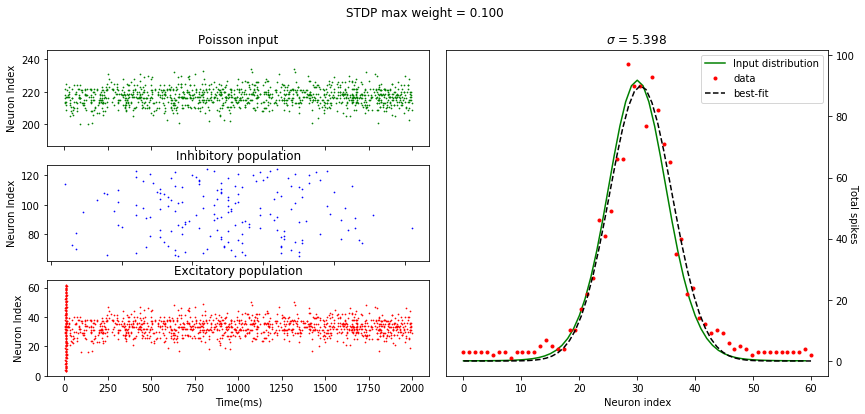

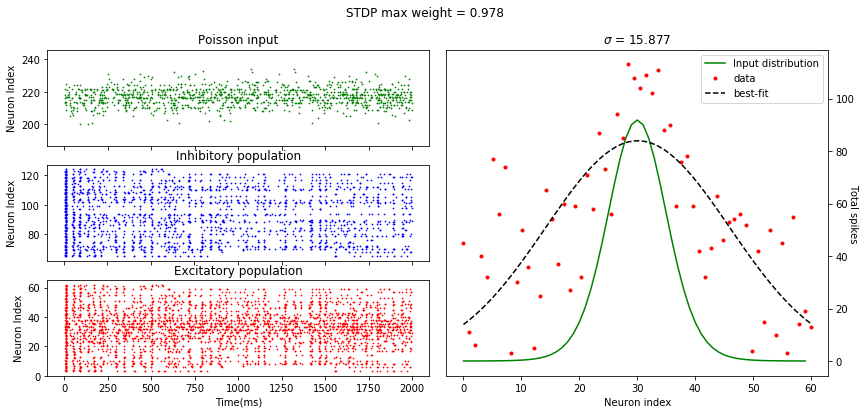

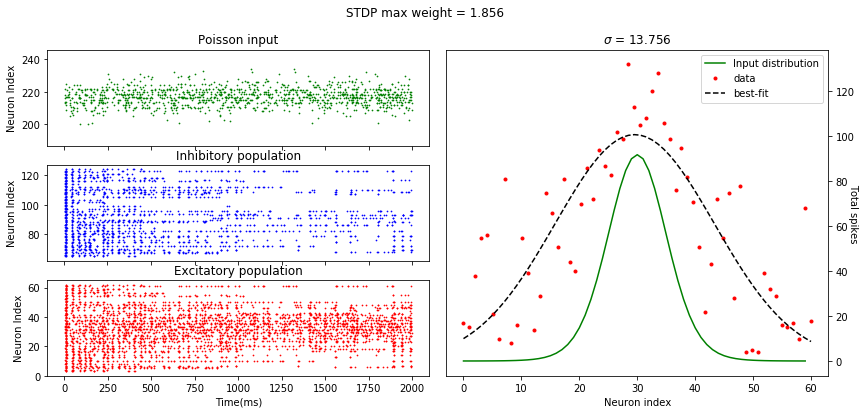

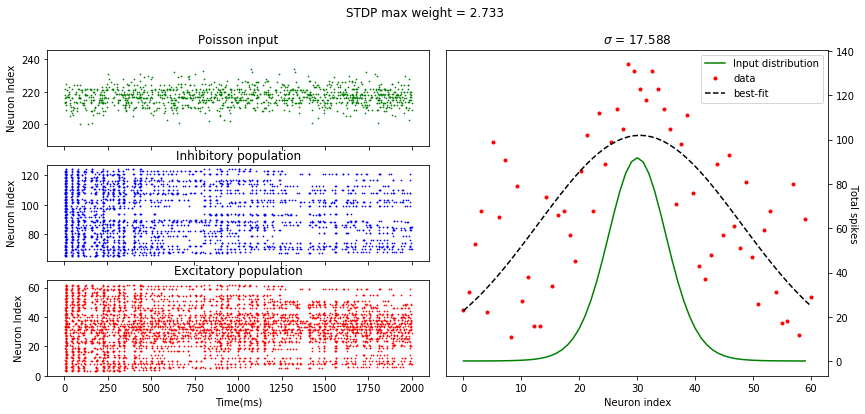

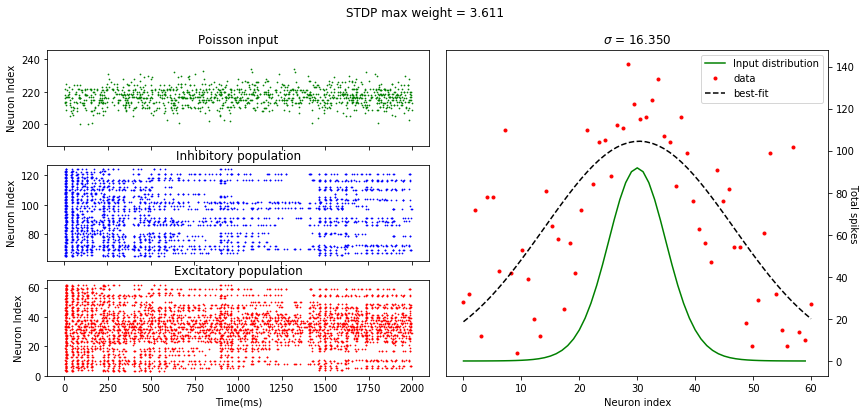

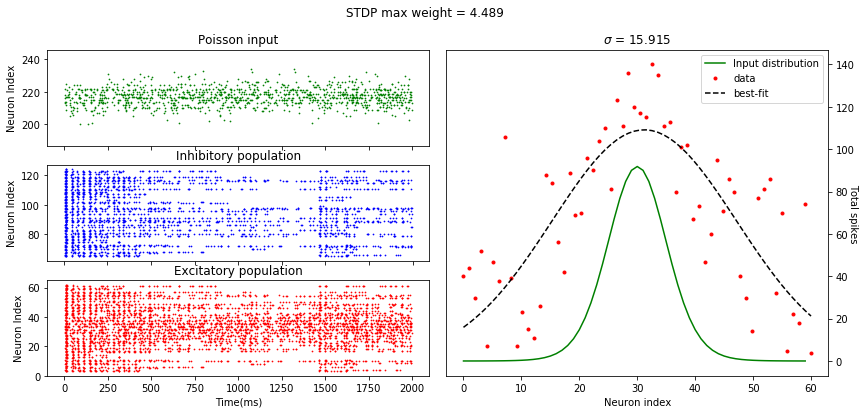

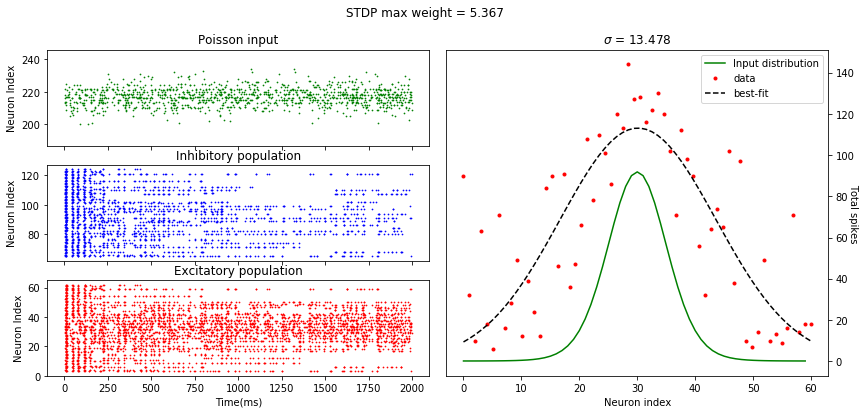

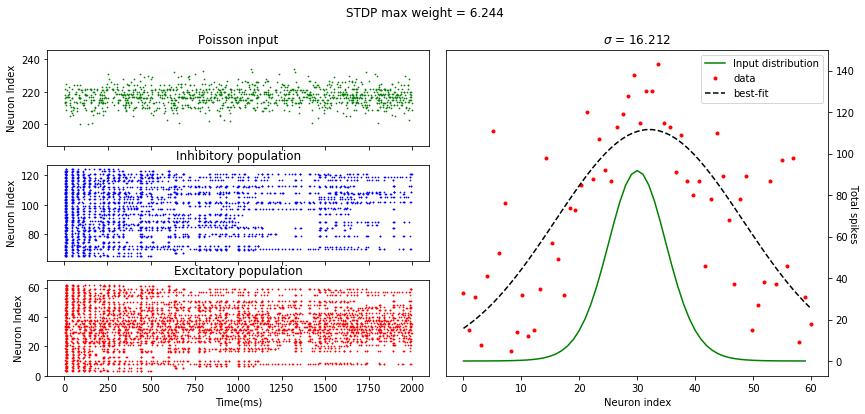

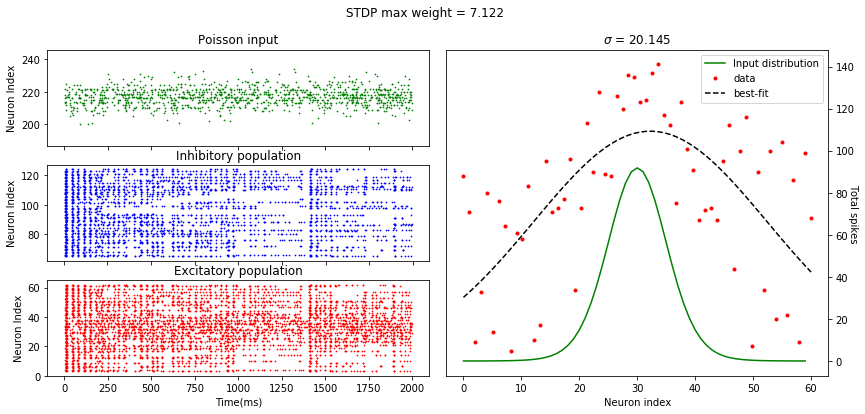

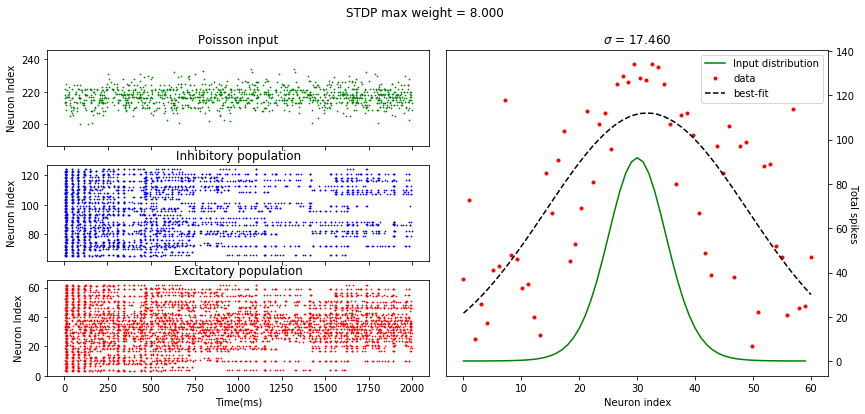

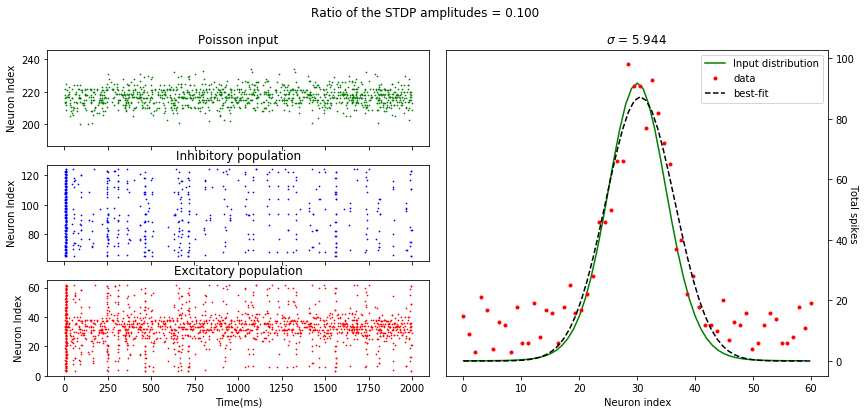

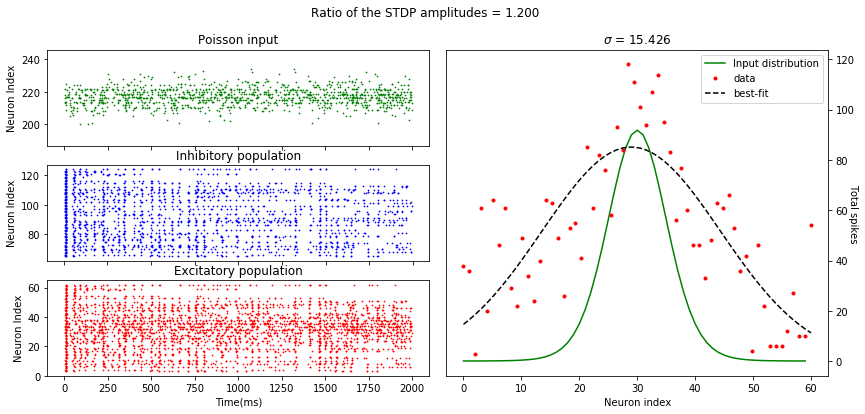

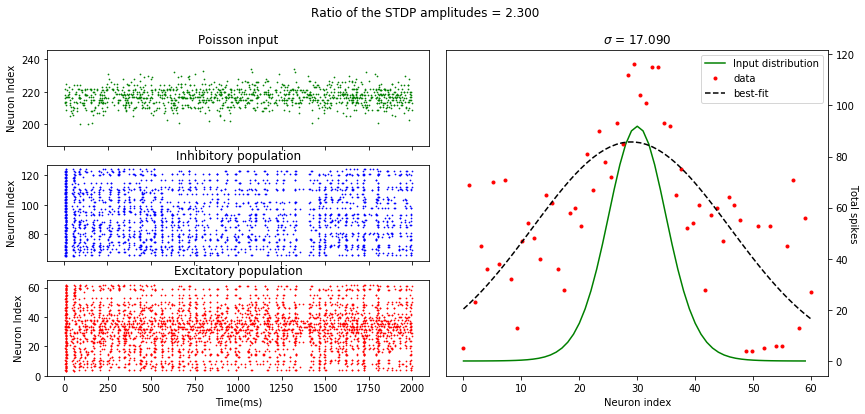

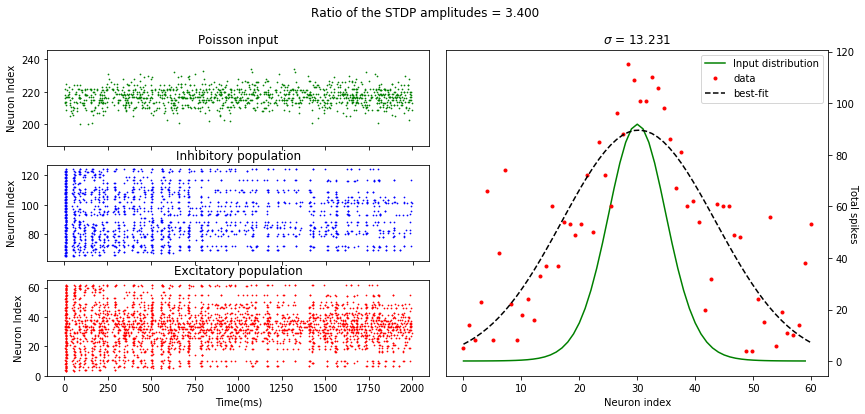

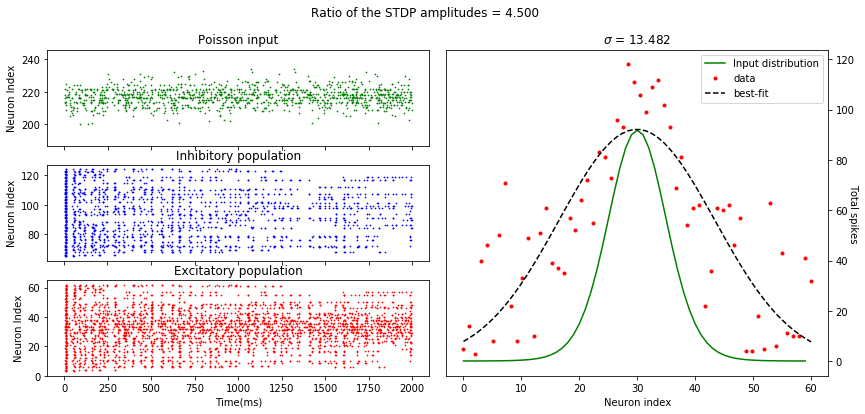

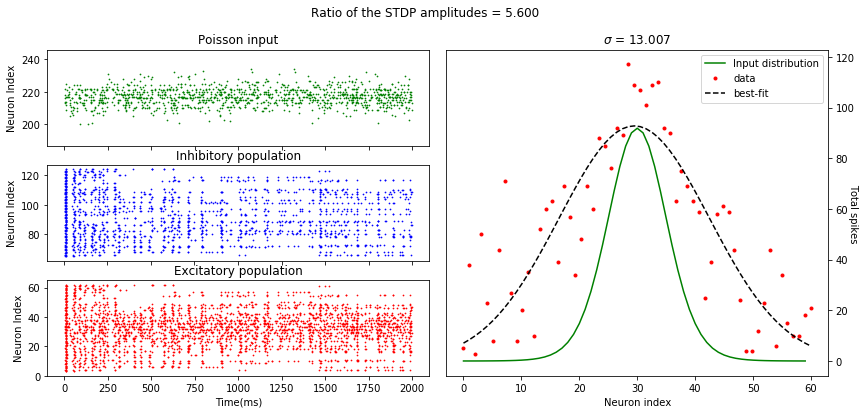

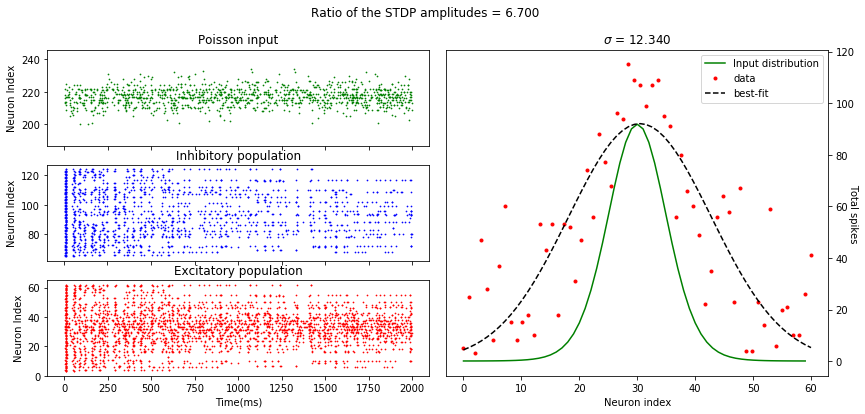

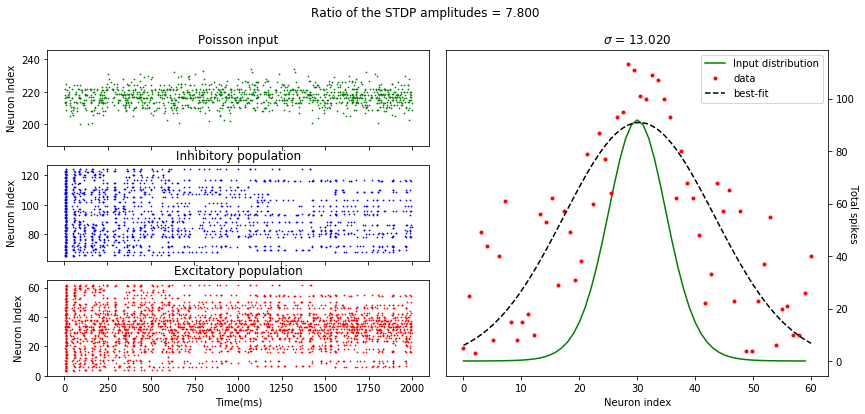

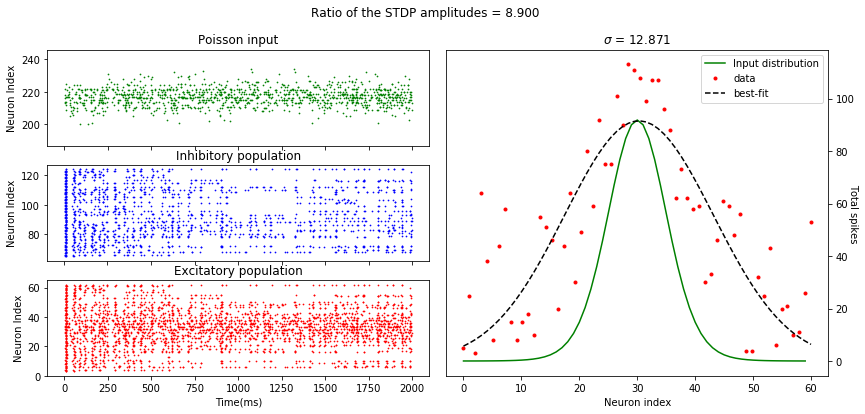

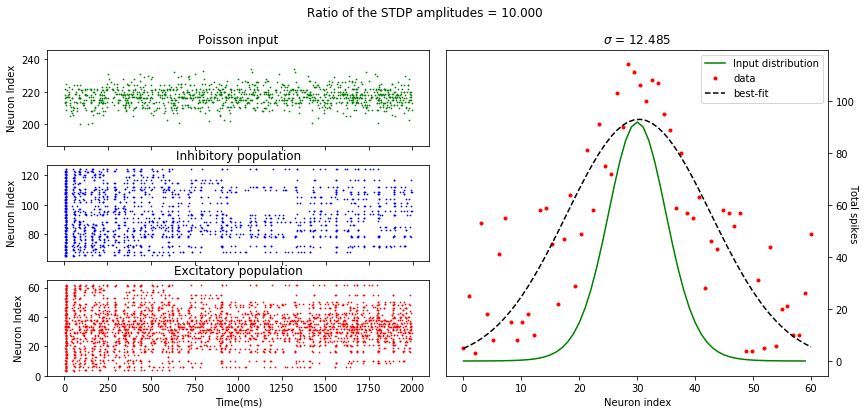

In [5]:
all_sigmas = []
for dict_iterator, param_dicos in enumerate(all_dicts):
    sigmas = []
    for param in param_dicos :
        
        #WEIGHTS SCANNING
        if dict_iterator == 3 :
            normal_weights = rnd('normal_clipped', mu=param, sigma=.2, low=0.1,
                                 high=5,
                                 rng=rng)
        else :
            normal_weights = rnd('normal_clipped', mu=.5, sigma=.2, low=0.1,
                         high=5,
                         rng=rng)
            
        #DELAYS SCANNING
        if dict_iterator == 4 :
            delays = rnd('normal_clipped', mu=param, sigma=.5, low=0.1,
                         high=5,
                         rng=rng)
        else :
            delays = rnd('normal_clipped', mu=2, sigma=.5, low=0.1,
                         high=5,
                         rng=rng)
            
        #STDP TAUS SCANNING
        #Both this one and the one below require an extra condition to make sure we
        #won't override by accident the scan done in the previous line
        if dict_iterator == 0:
            timing_dependence=sim.SpikePairRule(tau_plus=param, tau_minus=param,
                                                A_plus=0.9, A_minus=0.9)
        elif dict_iterator == 1:
            timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                A_plus=param, A_minus=param)
        else:
            timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                A_plus=.9, A_minus=.9)
            
        #STDP WEIGHT CONSTANT SCANNING
        if dict_iterator == 1:
            timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                A_plus=param, A_minus=param)
        elif dict_iterator == 0:
            timing_dependence=sim.SpikePairRule(tau_plus=param, tau_minus=param,
                                                A_plus=20., A_minus=20.)
        else :
            timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                A_plus=0.9, A_minus=0.9)
        
        if dict_iterator == 6 :
            timing_dependence=sim.SpikePairRule(tau_plus=20., tau_minus=20.,
                                                A_plus=param*1, A_minus=1)
            
        #STDP WEIGHT INITIATION SCANNING
        if dict_iterator == 2 :
            stdp_weight_init = param
        else :
            stdp_weight_init = 1
            
        #STDP MAX WEIGHT SCANNING
        if dict_iterator == 5 :
            stdp_max_w = param
        else :
            stdp_max_w = 1
            
        sim.setup(timestep=.1, threads=4)
        exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                             initial_values={"v": neuron_parameters["v_reset"]},
                             label="Neurones Exictateurs")

        inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                             initial_values={"v": neuron_parameters["v_reset"]},
                             label="Neurones Inhibiteurs")

        input_pop = sim.Population(n_pop,
                                   sim.SpikeSourcePoisson(
                                       rate=500, duration=simtime, start=0),
                                   label="Entree Orientation")
        
       
        STDP_syn = sim.STDPMechanism(
            timing_dependence=timing_dependence,
            weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
            weight=stdp_weight_init,
            delay=delays,
            dendritic_delay_fraction=1.)

        # Intras
        syn_exc_exc = sim.Projection(exc, exc,
                                     connector=sim.FixedProbabilityConnector(
                                         sparseness, rng=rng),
                                     synapse_type=STDP_syn,
                                     receptor_type='excitatory')
        syn_inh_inh = sim.Projection(inh, inh,
                                     connector=sim.FixedProbabilityConnector(
                                         sparseness, rng=rng),
                                     synapse_type=sim.StaticSynapse(
                                         weight=normal_weights, delay=delays),
                                     receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

        # Inters
        syn_exc_inh = sim.Projection(exc, inh,
                                     connector=sim.FixedProbabilityConnector(
                                         sparseness, rng=rng),
                                     synapse_type=STDP_syn,
                                     receptor_type='excitatory')
        syn_inh_ex = sim.Projection(inh, exc,
                                    connector=sim.FixedProbabilityConnector(
                                        sparseness, rng=rng),
                                    synapse_type=sim.StaticSynapse(
                                        weight=normal_weights, delay=delays),
                                    receptor_type='inhibitory')

        # Input
        syn_inp_exc = sim.Projection(input_pop, exc,
                                     connector=sim.OneToOneConnector(),
                                     synapse_type=sim.StaticSynapse(
                                         weight=1, delay=1),
                                     receptor_type='excitatory')

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
        rates /= rates.mean()
        rates *= rate_gain
        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])

        exc.record('spikes')
        inh.record('spikes')
        input_pop.record('spikes')
        sim.run(simtime)
        sim.end()

        exc_data = exc.get_data().segments[0]
        inh_data = inh.get_data().segments[0]
        inp_data = input_pop.get_data().segments[0]
        
        fig, sigma = SuperPlotter(inp_data, exc_data, inh_data,
                     60, rates, simtime,
                     title= titles[dict_iterator] + ' = %.3f' % (param),
                     figsize = (14,6)
                     )
        sigmas.append(sigma)
        #fit_plot(n_pop, exc_data)

        plt.show()
        '''if iterator == 0 or iterator == 7 :
            fig.savefig('./figs/2018_12_10_RING_STDP_tau_iter%s.pdf'%iterator, format = 'pdf', dpi = 200)'''

        plt.pause(.1)
    all_sigmas.append(sigmas)

# Influence of each parameter on the output tuning curve

Text(0.5, 1.0, 'Effect of various parameters on the network output')

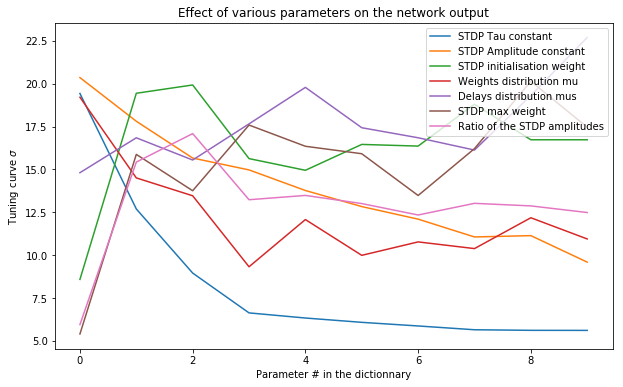

In [6]:
plt.figure(figsize = (10,6))

for sig_it, sigmas in enumerate(all_sigmas):
    plt.plot(sigmas, label = titles[sig_it])
    
plt.legend(loc = 1)
plt.xlabel('Parameter # in the dictionnary')
plt.ylabel(r'Tuning curve $\sigma$')
plt.title('Effect of various parameters on the network output')

We can now suppose, excluding default parameters interference :

An optimal network has initialisation and max STDP weight of :

In [7]:
stdp_max_weight[1]

0.9777777777777777

A half amplitude STDP height of 

In [8]:
stdp_amps[6]

4.033333333333333

A mean inhibitory weight of 

In [9]:
print(weight_mus[3])
print('which is')
print(stdp_max_weight[1]/weight_mus[3])
print('the weight of excitatories')

1.7333333333333336
which is
0.564102564102564
the weight of excitatories


A STDP tau constant of 

In [10]:
taus[4]

29.444444444444443

Most interestingly, it works better when the shape is not balanced, meaning that STDP doesn't have to increase weight that much but it needs to hugely penalise neurons that aren't synchronous

In [11]:
ratio_weights[0]

0.1

# Now let's try one with all optimal parameters

In [12]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 90  # degrees
b_theta = 30  # degrees
sparseness = .1

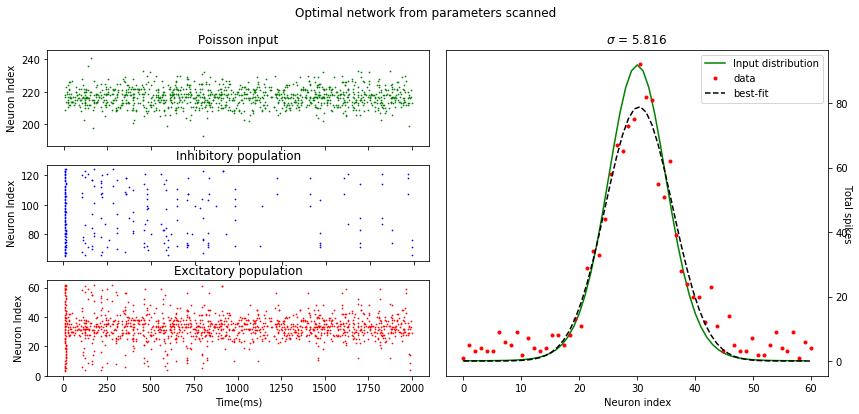

In [13]:
normal_weights = rnd('normal_clipped', mu=1.5, sigma=.2, low=0.1,
             high=5,
             rng=rng)

delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
             high=5,
             rng=rng)

timing_dependence=sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                    A_plus=1, A_minus=10)

stdp_weight_init = 1
stdp_max_w = 1

sim.setup(timestep=.1, threads=4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=500, duration=simtime, start=0),
                           label="Entree Orientation")


STDP_syn = sim.STDPMechanism(
    timing_dependence=timing_dependence,
    weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=sim.StaticSynapse(
                                 weight=normal_weights, delay=delays),
                             receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_ex = sim.Projection(inh, exc,
                            connector=sim.FixedProbabilityConnector(
                                sparseness, rng=rng),
                            synapse_type=sim.StaticSynapse(
                                weight=normal_weights, delay=delays),
                            receptor_type='inhibitory')

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1),
                             receptor_type='excitatory')

angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime)
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig, sigma = SuperPlotter(inp_data, exc_data, inh_data,
             60, rates, simtime,
             title= 'Optimal network from parameters scanned',
             figsize = (14,6)
             )
sigmas.append(sigma)
#fit_plot(n_pop, exc_data)

plt.show()
fig.savefig('./figs/2018_12_10_Optim_ring.pdf', format = 'pdf', dpi = 200)